
# Defining an APB Model in Python

In order to Verify our Register File Generator, we'll define an executable APB
Model as a Python an object.  We'll use this model to generate the low-level
input stimuli for issuing requests over the APBBus.

This implementation is based on the [ARM AMBA 3 APB Protocol
Specification](https://static.docs.arm.com/ihi0024/b/AMBA3apb.pdf), Copyright ©
2003, 2004. ARM Limited. All rights reserved.  

The basic architecture of our APBModel will be a Python object that translates
various APB bus requests into low-level input stimuli.  That is, we'd like
interface where can tell the model to write some data to a specifc address.
The model is responsible for translating that request into a sequence of cycle
accurate inputs for the APBBus.  Because this is a two way protocol, we'll also
need a mechanism for providing inputs to the APB model that come from the slave
(i.e. the `PREADY` line which a slave uses to indicate that a request has been
processed).

First, we define a helper function that will be used to cache our Python type
generators.  This is essential so we can do comparisons of generated types
(i.e. check if `type0 == type1`) by doing object equality.  Consider the
following Python code for dynamically constructing a class with a parameter `n`
that is used to set a class attribute `n`.

In [1]:
def make_A(n):
    class A:
        __n = n
    return A

Suppose we'd like to compare the equality of two invocations of this class
factory function with the same parameter

In [2]:
make_A(3) == make_A(3)

False

In this case, we'd like the result to be `True`. There's a few ways to handle
this issue, but we'll use a cache based pattern to cache objects created
by the `make_A` function based on the input parameter.  Python provides
a built in library function to do this called `functools.lru_cache`
(https://docs.python.org/3/library/functools.html#functools.lru_cache).

In [3]:
from functools import lru_cache

@lru_cache(maxsize=None)
def make_A(n):
    class A:
        __n = n
    return A

make_A(3) == make_A(3)

True

`functools.lru_cache` memoizes calls to the function, but by default it doesn't
handle keyword arguments with default values. 

In [4]:
@lru_cache(maxsize=None)
def make_A(n=3):
    class A:
        __n = n
    return A

make_A(3) == make_A()

False

To remedy this, we'll augment it with another decorater based on
https://stackoverflow.com/questions/36771866/memoization-caching-with-default-optional-arguments

In [5]:
import inspect
from functools import wraps


def canonicalize_args(f):
    """Wrapper for functools.lru_cache() to canonicalize default
    and keyword arguments so cache hits are maximized."""

    @wraps(f)
    def wrapper(*args, **kwargs):
        sig = inspect.getfullargspec(f.__wrapped__)

        # build newargs by filling in defaults, args, kwargs
        newargs = [None] * len(sig.args)
        if sig.defaults is not None:
            newargs[-len(sig.defaults):] = sig.defaults
        newargs[:len(args)] = args
        for name, value in kwargs.items():
            newargs[sig.args.index(name)] = value

        return f(*newargs)

    return wrapper

Let's try it out

In [6]:
@canonicalize_args
@lru_cache(maxsize=None)
def make_A(n=3):
    class A:
        __n = n
    return A

make_A(3) == make_A()

True

With this cacheing infrastructure in place, we'll now move on to defining our
APB type generators as Python functions that return Python types modeling
various components of the APB interface.

First we'll define an enumerated type to model our APB commands.  We'll do this
using the base types provided by the
[hwtypes](https://github.com/leonardt/hwtypes) Python package which provides
various convenient algebraic data types (ADTs) including `Enum` and `Product`
(we'll use Product next).


In [7]:
from hwtypes import Enum, Product

class APBCommand(Enum):
    READ = 0
    WRITE = 1
    IDLE = 2

Now we'll define an `APB` type generator by extending Peak's `Product` type.
Our complex APB type will be defined in terms of the more basic `Bit` and
`BitVector` types from the [hwtypes](https://github.com/leonardt/hwtypes)
package.  These types provide a Python executable model for fixed width bit
vectors and single bits with various operators defined.

Here's an example of using these types

In [8]:
from hwtypes import Bit, BitVector

a = Bit(0)
b = Bit(1)
print(f"a ^ b = {a ^ b}")


c = BitVector[4](0xE)
d = BitVector[4](0xF)
print(f"~c & d = {~c & d}")

a ^ b = Bit(True)
~c & d = 1


Our APB type generator will create a `Product` type (similar to a struct in C)
with fields corresponding to each port in the APB specification as defined in
Table 4-1 (page 4-2) of the [APB
Specification](https://static.docs.arm.com/ihi0024/b/AMBA3apb.pdf)

In [9]:
import math

@canonicalize_args
@lru_cache(maxsize=None)
def APB(addr_width, data_width, num_slaves=1):
    """
    Constructs a concrete APB type based on the `addr_width`, `data_width` and
    `num_slaves` parameters.  Rather than using the standard subclassing
    syntax, we dynamically construct a dictionary containing our field names
    and types, then use Python's `type` function to construct our new type
    definition.

    This allows us to dynamically add more fields based on the number of
    slaves.
    """
    strobe_width = math.ceil(data_width / 8)

    fields = {
        "PADDR": BitVector[addr_width],
        "PWRITE": Bit,
    }

    # Dynamically add `PSELx` fields based on `num_slaves` parameter
    for i in range(num_slaves):
        fields[f"PSEL{i}"] = Bit

    fields.update({
        "PENABLE": Bit,
        "PWDATA": BitVector[data_width],
        "PRDATA": BitVector[data_width],
        "PREADY": Bit,
        "PSTRB": BitVector[strobe_width],
        "PPROT": Bit,
        "SLVERR": Bit,
    })

    result = type("_APB", (Product, ), fields)
    return result


def default_APB_instance(_APB):
    """
    Convenience function to instantiate an _APB object with default values of 0
    """
    fields = {}
    for key, value in _APB.field_dict.items():
        fields[key] = value(0)
    return _APB(**fields)

Let's test it out


In [10]:
_APB = APB(16, 32, num_slaves=2)

import pprint
pp = pprint.PrettyPrinter()
# We can use the `field_dict` property to fetch a dictionary mapping fields to
# types in our concrete type definition
print("========= Type  ==========")
pp.pprint(dict(_APB.field_dict))
print("==========================")
# For an instance of the type, we can use `value_dict` to fetch a dictionary
# mapping fields to values
print("===== Default Value ======")
pp.pprint(dict(default_APB_instance(_APB).value_dict))
print("==========================")

========= Type  ==========
{'PADDR': <class 'hwtypes.bit_vector.BitVector[16]'>,
 'PENABLE': <class 'hwtypes.bit_vector.Bit'>,
 'PPROT': <class 'hwtypes.bit_vector.Bit'>,
 'PRDATA': <class 'hwtypes.bit_vector.BitVector[32]'>,
 'PREADY': <class 'hwtypes.bit_vector.Bit'>,
 'PSEL0': <class 'hwtypes.bit_vector.Bit'>,
 'PSEL1': <class 'hwtypes.bit_vector.Bit'>,
 'PSTRB': <class 'hwtypes.bit_vector.BitVector[4]'>,
 'PWDATA': <class 'hwtypes.bit_vector.BitVector[32]'>,
 'PWRITE': <class 'hwtypes.bit_vector.Bit'>,
 'SLVERR': <class 'hwtypes.bit_vector.Bit'>}
===== Default Value ======
{'PADDR': BitVector[16](0),
 'PENABLE': Bit(False),
 'PPROT': Bit(False),
 'PRDATA': BitVector[32](0),
 'PREADY': Bit(False),
 'PSEL0': Bit(False),
 'PSEL1': Bit(False),
 'PSTRB': BitVector[4](0),
 'PWDATA': BitVector[32](0),
 'PWRITE': Bit(False),
 'SLVERR': Bit(False)}


Now we'll define a type generator for an APB Request as a Product type with
fields for a command, address, data, and slave id.  This type will be used
to initiate a request using the model.


In [11]:
@canonicalize_args
@lru_cache(maxsize=None)
def Request(addr_width, data_width, num_slaves):
    class _Request(Product):
        command = APBCommand
        address = BitVector[addr_width]
        data = BitVector[data_width]
        slave_id = BitVector[max(math.ceil(math.log2(num_slaves)), 1)]
    return _Request

Let's test it out


In [12]:
_Request = Request(16, 32, 2)

print("========= Type  ==========")
pp.pprint(dict(_Request.field_dict))
print("==========================")
request_val = _Request(APBCommand.WRITE, BitVector[16](0xDE),
                       BitVector[32](0xBEEF), BitVector[1](1))
print("===== Default Value ======")
pp.pprint(dict(request_val.value_dict))
print("==========================")

========= Type  ==========
{'address': <class 'hwtypes.bit_vector.BitVector[16]'>,
 'command': APBCommand,
 'data': <class 'hwtypes.bit_vector.BitVector[32]'>,
 'slave_id': <class 'hwtypes.bit_vector.BitVector[1]'>}
===== Default Value ======
{'address': BitVector[16](222),
 'command': APBCommand.WRITE,
 'data': BitVector[32](48879),
 'slave_id': BitVector[1](1)}


We'll define a similar type to model the IO of our APBBus master which will
consist of a request to execute and an APBBus.  We'll use `request` to initiate
a request with the model and `apb` to sample the input stimuli.


In [13]:
@canonicalize_args
@lru_cache(maxsize=None)
def APBBusIO(addr_width, data_width, num_slaves=1):
    class IO(Product):
        apb = APB(addr_width, data_width, num_slaves)
        request = Request(addr_width, data_width, num_slaves)
    return IO

Let's test it out


In [14]:
_APBBusIO = APBBusIO(16, 32, 2)

print("========= Type  ==========")
pp.pprint(dict(_APBBusIO.field_dict))
print("==========================")
print("===== Default Value ======")
pp.pprint(dict(_APBBusIO(default_APB_instance(_APB), request_val).value_dict))
print("==========================")

========= Type  ==========
{'apb': Product('_APB', PADDR=BitVector[16], PWRITE=Bit, PSEL0=Bit, PSEL1=Bit, PENABLE=Bit, PWDATA=BitVector[32], PRDATA=BitVector[32], PREADY=Bit, PSTRB=BitVector[4], PPROT=Bit, SLVERR=Bit),
 'request': Product('_Request', command=APBCommand, address=BitVector[16], data=BitVector[32], slave_id=BitVector[1])}
===== Default Value ======
{'apb': _APB(BitVector[16](0),Bit(False),Bit(False),Bit(False),Bit(False),BitVector[32](0),BitVector[32](0),Bit(False),BitVector[4](0),Bit(False),Bit(False)),
 'request': _Request(APBCommand.WRITE,BitVector[16](222),BitVector[32](48879),BitVector[1](1))}


Now we'll define a Python coroutine to model our APBBus with the ability to
mock requests from a master.  The behavior of the coroutine will emulate the
cycle-accurate behavior of the bus.  Thus, advancing the coroutine once will
model advancing one clock cycle in time.  IO with the model will be perfromed
by setting the `io` attribute (e.g. perform a read request by setting
`io.request` and then advancing the coroutine and sampling the output values of
`io.apb`).


In [15]:
@canonicalize_args
@lru_cache(maxsize=None)
def APBBus(addr_width, data_width, num_slaves=1):
    # TODO: Does this need to be a generator?
    class APBBus:
        """
        This defines a coroutine that impelements the behavior of an APBBus.  The interface
        to the coroutine is via the `__call__` method which accepts an instance
        of the `APBBusIO` type.
        """
        def __init__(self):
            # Store the type of the interface so users can easily fetch it
            self.IO = APBBusIO(addr_width, data_width, num_slaves)

            # The main functionality of the coroutine is defined the `_main`
            # method.  Because of how Python generators work, to emulate the
            # standard behavior of a coroutine, the main function should be
            # invoked once to create the generator object, then `next` is
            # called to initialize the coroutine
            # See http://www.dabeaz.com/coroutines/ for more info on Python
            # coroutines
            self.main = self._main()
            next(self.main)
            # TODO: This logic should move to the infrastructure and be
            # provided as a simple way to construct a coroutine

        def __call__(self, io):
            """
            Calling the object equates to advancing the coroutine once.
            IO is performed through the `io` attribute.
            """
            self.io = io
            self.main.send(None)

        def _main(self):
            """
            This main coroutine implements a state machine with three top-level
            states corresponding to: reading, writing, and idleing.
            """
            yield  # Initial state
            while True:
                if self.io.request.command == APBCommand.READ:
                    yield from self.read(self.io.request.address,
                                         self.io.request.data)
                elif self.io.request.command == APBCommand.WRITE:
                    yield from self.write(self.io.request.address,
                                          self.io.request.data)
                else:
                    yield

        def set_psel(self, value):
            """
            Helper function that sets the correct PSEL line based on the
            `slave_id` of the current request
            """
            setattr(self.io.apb, f"PSEL{self.io.request.slave_id}", value)

        def write(self, address, data):
            """
            Issue a write as a sequence of output values:
                * Set the address and write data lines based on the input
                * Set PSEL for the requested slave
                * Set PWRITE
                * Wait one clock cycle
                * Set PENABLE
                * Wait one clock cycle
                * Wait for PREADY to be high (from the slave)
                * Clear PENABLE and PSEL
            """
            self.io.apb.PADDR = address
            self.io.apb.PWDATA = data
            self.set_psel(Bit(1))
            self.io.apb.PWRITE = Bit(1)
            yield
            self.io.apb.PENABLE = Bit(1)
            yield
            while not self.io.apb.PREADY:
                # TODO: Insert timeout logic
                yield
            self.io.apb.PENABLE = Bit(0)
            self.set_psel(Bit(0))

        def read(self, address, data):
            """
            Issue a read as a sequence of output values:
                * Set the address line based on the input
                * Set PSEL for the requested slave
                * Clear PWRITE
                * Wait one clock cycle
                * Set PENABLE
                * Wait one clock cycle
                * Wait for PREADY to be high (from the slave)
                * Clear PENABLE and PSEL
            """
            self.io.apb.PADDR = address
            self.set_psel(Bit(1))
            self.io.apb.PWRITE = Bit(0)
            yield
            self.io.apb.PENABLE = Bit(1)
            yield
            while not self.io.apb.PREADY:
                # TODO: Insert timeout logic
                yield
            self.io.apb.PENABLE = Bit(0)
            self.set_psel(Bit(0))

            # TODO: Handle PSLVERR and checking the expected data
    return APBBus()

Now with our APBBus model defined, we should test it to verify that it
generates the appropriate input stimuli for various commands.  To do this,
we'll use the `waveform` package to generate a visual representation of the
cycle level behavior of the model.  Here's an example of using the waveform
module with the APB type.

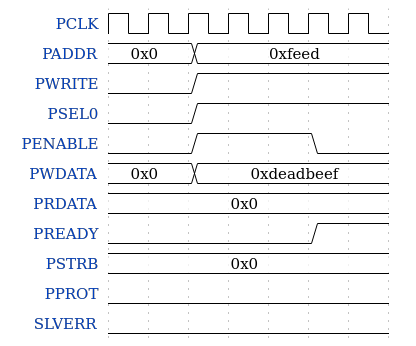

In [16]:
from waveform import WaveForm


_APB = APB(16, 32)
apb_fields = (field for field in _APB.field_dict)

waveform = WaveForm(apb_fields, clock_name="PCLK")
apb = default_APB_instance(_APB)

# Record intial state
waveform.step(apb)

# Step the clock
apb.PCLK = Bit(1)
waveform.step(apb)

# Set some other fields
apb.PWDATA = BitVector[32](0xDEADBEEF)
apb.PADDR = BitVector[16](0xFEED)
apb.PENABLE = Bit(1)
apb.PSEL0 = Bit(1)
apb.PWRITE = Bit(1)
apb.PCLK = Bit(0)
waveform.step(apb)

for i in range(2):
# Step the clock
    apb.PCLK ^= apb.PCLK
    waveform.step(apb)

apb.PREADY = Bit(1)
apb.PENABLE = Bit(0)

for i in range(2):
    apb.PCLK ^= apb.PCLK
    waveform.step(apb)

waveform.render_ipynb("waveform_example")

Now we will write a test sequence of inputs to the model and record the outputs
to verify the behavior for a write with no wait states.  Our expected output
waveform should look similar to Figure 2-1 (page 2-2) of the [APB
Specification](https://static.docs.arm.com/ihi0024/b/AMBA3apb.pdf)

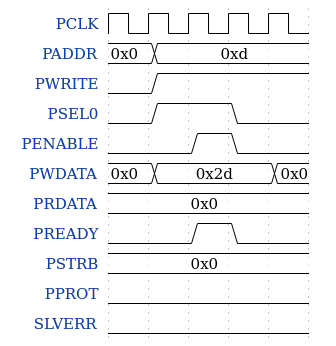

In [17]:
addr_width = 16
data_width = 32
bus = APBBus(addr_width, data_width)
addr = 13
data = 45
request = Request(addr_width, data_width, 1)(
    APBCommand.IDLE, BitVector[addr_width](addr),
    BitVector[data_width](data), BitVector[1](0))

# Specialized instance of APB for addr/data width
_APB = APB(addr_width, data_width)

io = APBBusIO(addr_width, data_width)(default_APB_instance(_APB), request)

apb_fields = (field for field in _APB.field_dict)
waveform = WaveForm(apb_fields, clock_name="PCLK")

# check idle stae
for i in range(1):
    bus(io)
    waveform.step(bus.io.apb)

# Send request
request.command = APBCommand.WRITE
bus(io)
assert io.apb.PSEL0 == 1

waveform.step(bus.io.apb)

request.command = APBCommand.IDLE

# No wait state
io.apb.PREADY = Bit(1)
bus(io)
waveform.step(bus.io.apb)

assert io.apb.PENABLE == 1
assert io.apb.PSEL0 == 1

bus(io)
# Slave pulls PREADY down at the same time
io.apb.PREADY = Bit(0)
waveform.step(bus.io.apb)

assert io.apb.PENABLE == 0
assert io.apb.PSEL0 == 0

io.apb.PWDATA = BitVector[data_width](0)

bus(io)
waveform.step(bus.io.apb)
waveform.render_ipynb("write_no_wait")

Next is a test for a write with a wait state which should look like Figure 2-2
(pg 2-3) of the [APB
Specification](https://static.docs.arm.com/ihi0024/b/AMBA3apb.pdf)


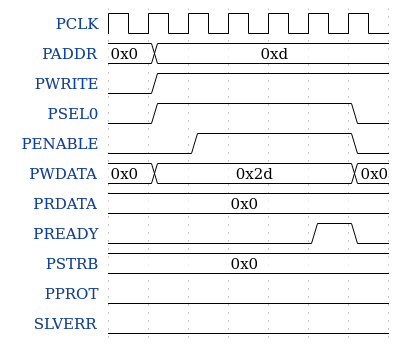

In [18]:
addr_width = 16
data_width = 32
bus = APBBus(addr_width, data_width)
addr = 13
data = 45
request = Request(addr_width, data_width, 1)(
    APBCommand.IDLE, BitVector[addr_width](addr), BitVector[data_width](data), BitVector[1](0))

# Specialized instance of APB for addr/data width
_APB = APB(addr_width, data_width)

io = APBBusIO(addr_width, data_width)(
    default_APB_instance(_APB), request)

apb_fields = (field for field in _APB.field_dict)
waveform = WaveForm(apb_fields, clock_name="PCLK")

# check idle stae
for i in range(1):
    bus(io)
    waveform.step(bus.io.apb)

# Send request
request.command = APBCommand.WRITE
bus(io)
waveform.step(bus.io.apb)
assert io.apb.PSEL0 == 1
assert io.apb.PWRITE == 1

request.command = APBCommand.IDLE

# Wait by holding PREADY down
io.apb.PREADY = Bit(0)
bus(io)
waveform.step(bus.io.apb)
assert io.apb.PENABLE == 1
assert io.apb.PSEL0 == 1
assert io.apb.PWRITE == 1

for i in range(2):
    bus(io)
    waveform.step(bus.io.apb)
    assert io.apb.PENABLE == 1
    assert io.apb.PSEL0 == 1
    assert io.apb.PWRITE == 1

bus(io)
# PREADY high when done
io.apb.PREADY = Bit(1)
waveform.step(bus.io.apb)
bus(io)
io.apb.PREADY = Bit(0)
io.apb.PWDATA = BitVector[data_width](0)
waveform.step(bus.io.apb)
assert io.apb.PENABLE == 0
assert io.apb.PSEL0 == 0
waveform.render_ipynb("write_with_wait")

Similarly we can test a read with no wait which should look like
Figure 2-3 (pg 2-4) of the [APB
Specification](https://static.docs.arm.com/ihi0024/b/AMBA3apb.pdf)


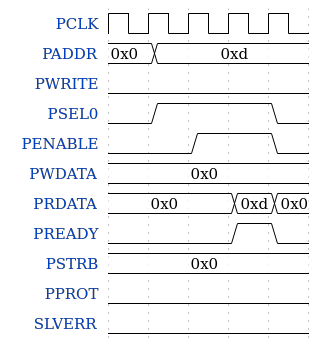

In [19]:
addr_width = 16
data_width = 32
bus = APBBus(addr_width, data_width)
addr = 13
data = 0
request = Request(addr_width, data_width, 1)(
    APBCommand.IDLE, BitVector[addr_width](addr), BitVector[data_width](data), BitVector[1](0))

# Specialized instance of APB for addr/data width
_APB = APB(addr_width, data_width)

io = APBBusIO(addr_width, data_width)(default_APB_instance(_APB), request)

apb_fields = (field for field in _APB.field_dict)
waveform = WaveForm(apb_fields, clock_name="PCLK")

# check idle stae
for i in range(1):
    bus(io)
    waveform.step(bus.io.apb)

# Send request
request.command = APBCommand.READ
bus(io)
waveform.step(bus.io.apb)

request.command = APBCommand.IDLE

bus(io)
waveform.step(bus.io.apb)
assert io.apb.PENABLE == 1

# No wait state
bus(io)
io.apb.PREADY = Bit(1)
io.apb.PRDATA = BitVector[data_width](13)
waveform.step(bus.io.apb)

bus(io)
io.apb.PREADY = Bit(0)
io.apb.PRDATA = BitVector[data_width](0)
waveform.step(bus.io.apb)

assert io.apb.PENABLE == 0
assert io.apb.PSEL0 == 0
waveform.render_ipynb("read_no_wait")

And test a read with a wait state which should look like Figure 2-4 (pg 2-5) of
the [APB Specification](https://static.docs.arm.com/ihi0024/b/AMBA3apb.pdf).


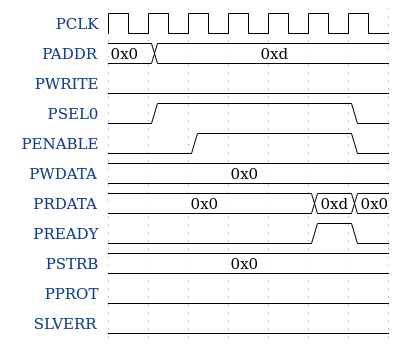

In [20]:
addr_width = 16
data_width = 32
bus = APBBus(addr_width, data_width)
addr = 13
data = 0
request = Request(addr_width, data_width, 1)(
    APBCommand.IDLE, BitVector[addr_width](addr), BitVector[data_width](data), BitVector[1](0))

# Specialized instance of APB for addr/data width
_APB = APB(addr_width, data_width)

io = APBBusIO(addr_width, data_width)(default_APB_instance(_APB), request)

apb_fields = (field for field in _APB.field_dict)
waveform = WaveForm(apb_fields, clock_name="PCLK")

# check idle stae
for i in range(1):
    bus(io)
    waveform.step(bus.io.apb)

# Send request
request.command = APBCommand.READ
bus(io)
waveform.step(bus.io.apb)

request.command = APBCommand.IDLE

bus(io)
waveform.step(bus.io.apb)
assert io.apb.PENABLE == 1

for i in range(2):
    bus(io)
    waveform.step(bus.io.apb)

bus(io)
io.apb.PREADY = Bit(1)
io.apb.PRDATA = BitVector[data_width](13)
waveform.step(bus.io.apb)

bus(io)
io.apb.PREADY = Bit(0)
io.apb.PRDATA = BitVector[data_width](0)
waveform.step(bus.io.apb)

assert io.apb.PENABLE == 0
assert io.apb.PSEL0 == 0
waveform.render_ipynb("write_no_wait")

In the next notebook, we'll demonstrate how to use this APBModel to verify the
register file.